In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    source('../utils_mapping.R')
    source('../utils_plotting.R')
})


# Enrichment analysis

In [6]:
dname <- '/data/srlab/ik936/Roche/data/cache/obj_fibroblasts/'
fields_load <- c('meta_data')
obj <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj) <- fields_load


In [9]:
## define this outside of obj so futures doesn't copy obj each time 
data_df <- obj$meta_data %>% 
    dplyr::mutate(
        Cluster = as.character(Cluster),
        Tissue = as.character(Tissue)
    ) %>% 
    dplyr::mutate(
        percent_mito = scale(percent_mito),
        scDblFinder.score = scale(scDblFinder.score)
    ) %>% 
    identity()


In [14]:
# data_df <- data.table(obj$meta_data)[
#     tissue_cluster != '' & !tissue_cluster %in% c('UNKNOWN', 'LOWQC', 'DOUBLET') & !is.na(tissue_cluster), 
#     .N, 
#     by = .(Cluster, Tissue, tissue_cluster)]
# head(data_df)


In [15]:
future::plan(multiprocess)
set.seed(1)

masc_res <- expand.grid(
    cluster_test = unique(data_df$Cluster), 
#         cluster_test = c('4'),
    tissue_test = unique(data_df$Tissue)
#         tissue_test = c('SalivaryGland')
) %>% 
future_pmap(function(cluster_test, tissue_test, ...) {
    message(paste(cluster_test, tissue_test))
    data_glmer <- data_df %>% 
        dplyr::mutate(Response = case_when(
            Cluster == cluster_test ~ 1L,
            TRUE ~ 0L
        )) %>% 
        subset(Tissue == tissue_test)
    
    tryCatch({
        model <- glmer(
            formula = Response ~ 1 + tissue_cluster + (scDblFinder.score+percent_mito||LibraryID), 
#             formula = Response ~ 1 + (1|tissue_cluster) + (scDblFinder.score+percent_mito||LibraryID), 
            data = data_glmer, 
            family = 'binomial'
        )

        ## Compute covariance
        sim_res <- arm::sim(model, n.sims = 1e3)
        covmat <- cov(as.data.frame(sim_res@ranef$tissue_cluster))
        rownames(covmat) <- gsub('..Intercept.', '', rownames(covmat))
        colnames(covmat) <- gsub('..Intercept.', '', colnames(covmat))

        ## Contrast matrix 
        terms <- unique(data_glmer$tissue_cluster)
        N <- length(terms)
        C <- (1 + 1/(N - 1)) * diag(nrow = N) + matrix(1/(1 - N), nrow = N, ncol = N)
        colnames(C) <- terms
        rownames(C) <- terms

        tibble(
            Cluster = cluster_test, 
            Tissue = tissue_test,
            tissue_cluster = terms, 
            beta = as.numeric(C %*% ranef(model)$tissue_cluster[terms, ]),
            sigma = sqrt(diag(C %*% covmat[terms, terms] %*% t(C)))
        ) %>% 
            dplyr::mutate(pvalue = 2 * (pnorm(-abs(beta / sigma)))) %>% 
            return()                
    }, error = function(e) {
        print(e)
        tibble(
            Cluster = cluster_test, 
            Tissue = tissue_test,
            tissue_cluster = terms, 
            beta = NA,
            sigma = NA
        ) %>% 
            dplyr::mutate(pvalue = NA) %>% 
            return()
    })
}) %>% bind_rows()


5 SalivaryGland

2 SalivaryGland

4 SalivaryGland

1 SalivaryGland

9 SalivaryGland

11 SalivaryGland

7 SalivaryGland

6 SalivaryGland

8 SalivaryGland

3 SalivaryGland

boundary (singular) fit: see ?isSingular

12 SalivaryGland

boundary (singular) fit: see ?isSingular

10 SalivaryGland

boundary (singular) fit: see ?isSingular

0 SalivaryGland

boundary (singular) fit: see ?isSingular

13 SalivaryGland

boundary (singular) fit: see ?isSingular

5 Gut

2 Gut

4 Gut

1 Gut

9 Gut

boundary (singular) fit: see ?isSingular

11 Gut

7 Gut

6 Gut

8 Gut

3 Gut

12 Gut

10 Gut

0 Gut

13 Gut

5 Lung

2 Lung

4 Lung

boundary (singular) fit: see ?isSingular

1 Lung

9 Lung

boundary (singular) fit: see ?isSingular

11 Lung

boundary (singular) fit: see ?isSingular

7 Lung

boundary (singular) fit: see ?isSingular

6 Lung

boundary (singular) fit: see ?isSingular

8 Lung

3 Lung

boundary (singular) fit: see ?isSingular

12 Lung

boundary (singular) fit: see ?isSingular

10 Lung

boundary (s

In [16]:
head(masc_res)

Cluster,Tissue,tissue_cluster,beta,sigma,pvalue
<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
5,SalivaryGland,CD34,0.7297092,0.05655376,4.332965e-38
5,SalivaryGland,CCL19,-0.7297092,0.05655376,4.332965e-38
2,SalivaryGland,CD34,-6.7688557,0.53240763,4.964757e-37
2,SalivaryGland,CCL19,6.7688557,0.53240763,4.964757e-37
4,SalivaryGland,CD34,3.1509585,0.15142355,3.594510e-96
4,SalivaryGland,CCL19,-3.1509585,0.15142355,3.594510e-96


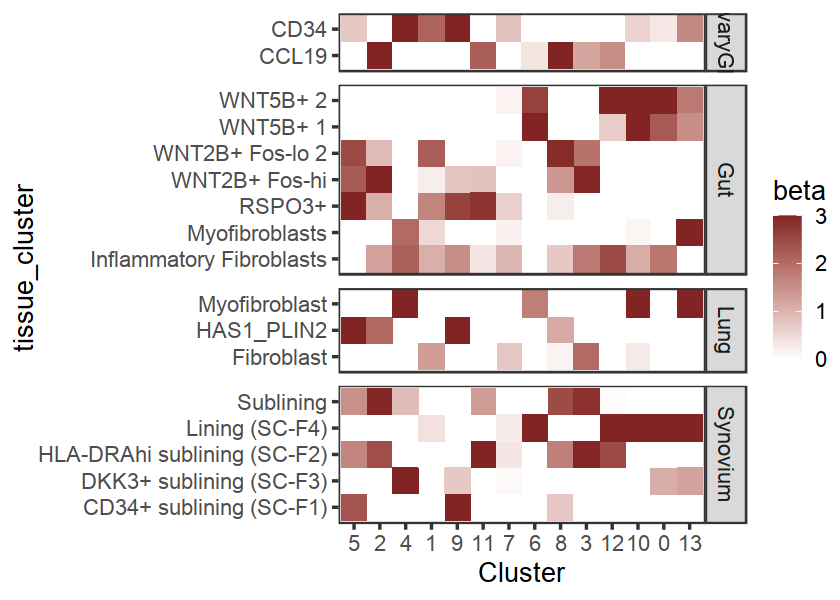

In [17]:
fig.size(5, 7)
masc_res %>% 
    arrange(-sigma) %>% 
    mutate(
        beta = pmin(beta, 3),
        beta = pmax(beta, 0)
    ) %>% 
    ggplot(aes(Cluster, tissue_cluster, fill = beta)) + 
        facet_grid(Tissue~., scales = 'free', space = 'free') + 
#         facet_wrap(~Tissue, scales = 'free_y') + 
        scale_fill_gradient2(midpoint = 0, high = muted('red'), low = 'white', mid = 'white') + 
#         scale_fill_gradient2(midpoint = 0, high = muted('red'), low = muted('blue'), mid = 'white') + 
        theme_test(base_size = 16) + 
        geom_tile()


In [ ]:
saveRDS(masc_res, '/data/srlab/ik936/Roche/data/cache/confusion_analysis_results.rds')


# Reverse direction

In [3]:
meta_data <- readRDS('/data/srlab/ik936/Roche/data/cache/obj_fibroblasts/meta_data.rds')

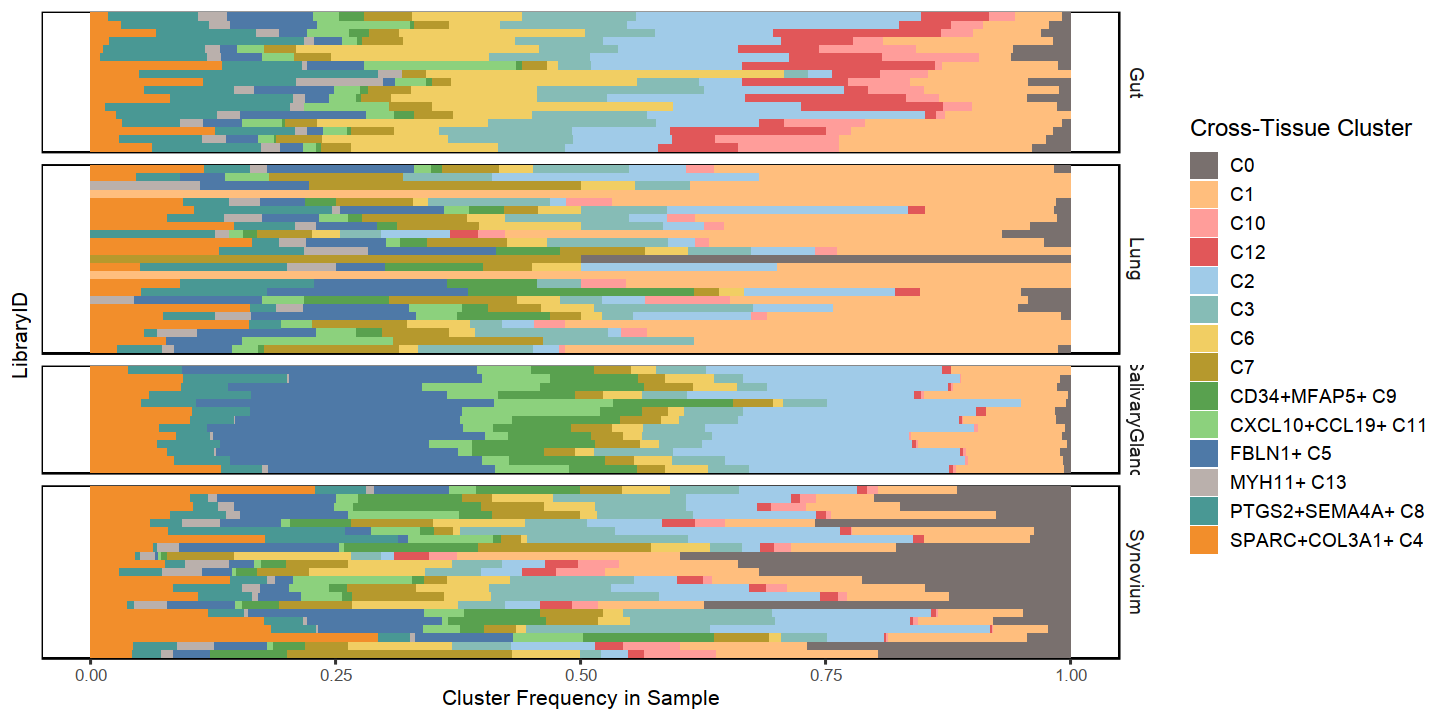

In [50]:
fig.size(6, 12)
p1 <- meta_data %>% 
    with(table(LibraryID, Tissue, Cluster_name)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    subset(N > 0) %>% 
    ggplot(aes(LibraryID, N, fill = Cluster_name)) + 
        geom_bar(stat = 'identity', position = position_fill()) + 
        scale_fill_manual(values = palette_global) + 
        theme(axis.text.y= element_blank(), axis.ticks.y = element_blank()) + 
        facet_grid(Tissue~., scales = 'free', space = 'free') + 
        coord_flip() + 
        labs(fill = 'Cross-Tissue Cluster', y = 'Cluster Frequency in Sample') + 
        NULL
p1

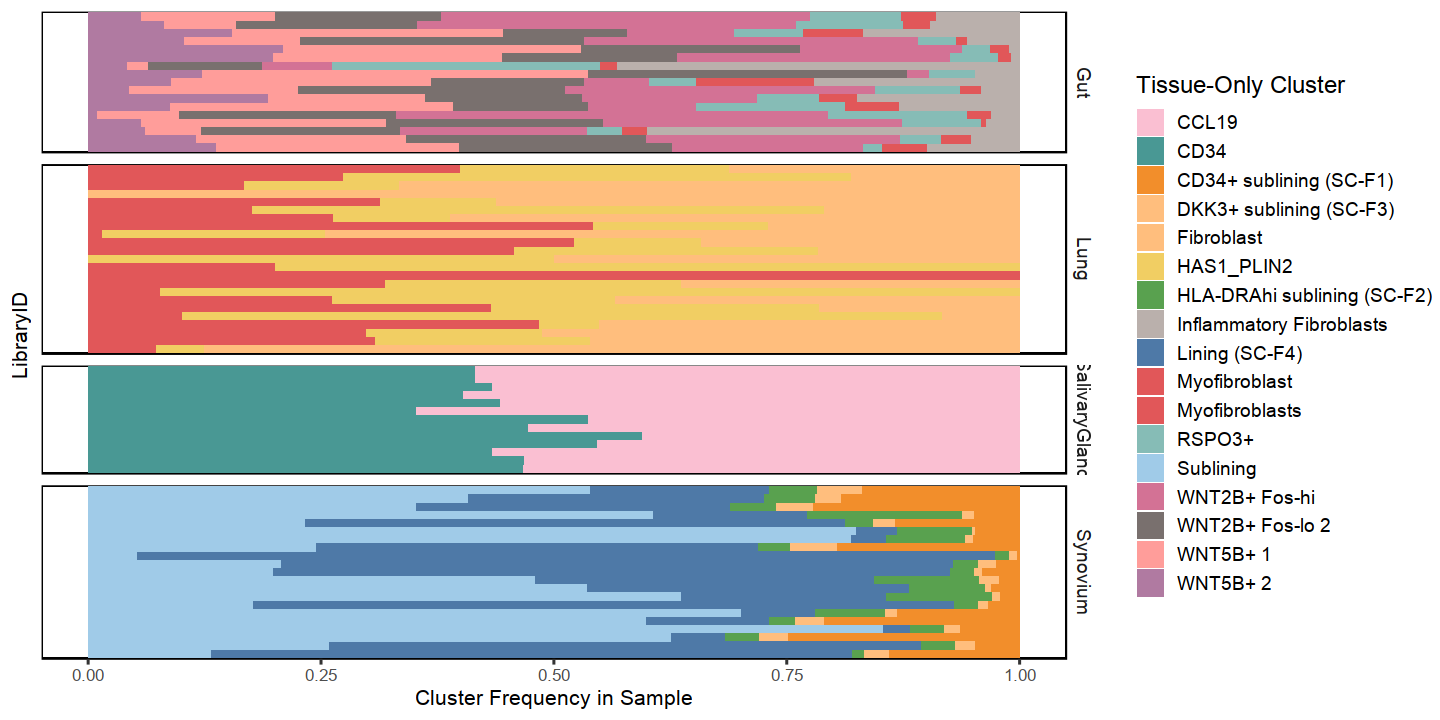

In [55]:
fig.size(6, 12)
p2 <- meta_data %>% 
    with(table(LibraryID, Tissue, tissue_cluster)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    subset(N > 0) %>% 
#     dplyr::mutate(tissue_cluster = glue('({Tissue}) {tissue_cluster}')) %>% 
    ggplot(aes(LibraryID, N, fill = tissue_cluster)) + 
        geom_bar(stat = 'identity', position = position_fill()) + 
        scale_fill_manual(values = palette_global) + 
        theme(axis.text.y= element_blank(), axis.ticks.y = element_blank()) + 
        facet_grid(Tissue~., scales = 'free', space = 'free') + 
        coord_flip() + 
        labs(fill = 'Tissue-Only Cluster', y = 'Cluster Frequency in Sample') + 
        NULL
p2

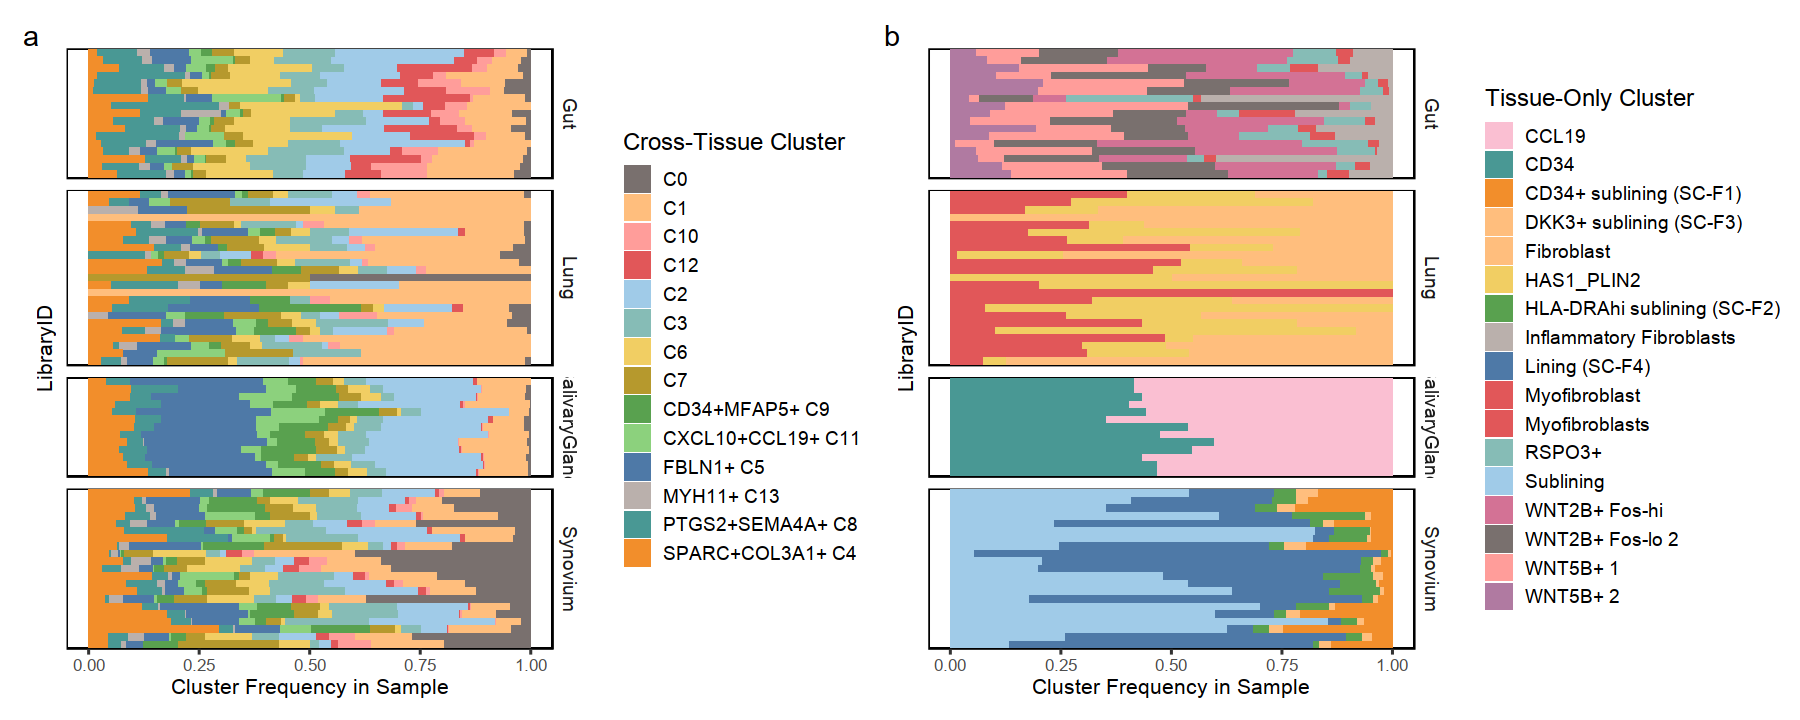

In [52]:
fig.size(6, 15)
(p1 | p2) + plot_annotation(tag_levels = 'a')